We consider a mixed sensitivity $H_\infty$ problem as in Part 4. The design is performed for the nominal plant. With the designed controller, we analyze robust stability of the closed loop system with respect to a multiplicative perturbation on the plant. Note that this is not a robust performance design, it is a nominal performance design and robust stability of this nominal design is tested.

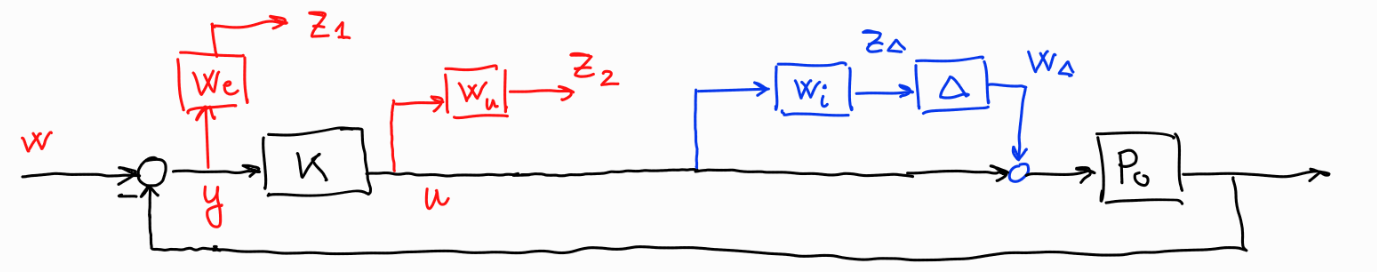

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import rpc_diism.robust as rb
s = ct.tf('s')

In [2]:
# Plant definition
num = [2,1]
den = [0.2, 1.2, 1]
P = ct.tf(num, den)

display("Plant transfer function", P)

# Weight on error
M = 1.5
e = 1e-4
wb = 0.25 # Crossover frequency
We = ct.ss(rb.weightS(wb, M, e, 1))

# Weight on command input
Mu = 1.5
eu = 1e-4
wbc = 10 
Wu = ct.ss(rb.weightU(wbc, Mu, eu, 1))

'Plant transfer function'

TransferFunction(
array([2, 1]),
array([0.2, 1.2, 1. ]),
outputs=1, inputs=1)

Generate the G block in the LFT corresponding to the given design using system interconnection functions.

In [3]:
# Define labels for system inputs and outputs in each block of the control loop
P.input_labels = ['u']
P.output_labels = ['yp']
We.input_labels = ['y']
We.output_labels = ['z1']
Wu.input_labels = ['u']
Wu.output_labels = ['z2'] 

# Negative feedback summing junction: y = r-v
fbk = ct.summing_junction(inputs=['w','-yp'], output=['y'])

# Generate the G transfer function of the LFT by interconnecting all blocks
G = ct.interconnect([P, We, Wu, fbk],
                    inputs=['w','u'],
                    outputs=['z1','z2','y'])


Solve the $H_\infty$ problem for the generated LFT

In [4]:
K, Tzw, gamma, rcond = rb.hinfsyn(G, nmeas=1, ncon=1)
display("gamma:", gamma)

'gamma:'

0.6926252552535885

Do singular value plot of the obtained closed loop sensitivities

Text(0.5, 1.0, 'S vs. gamma*inv(We)')

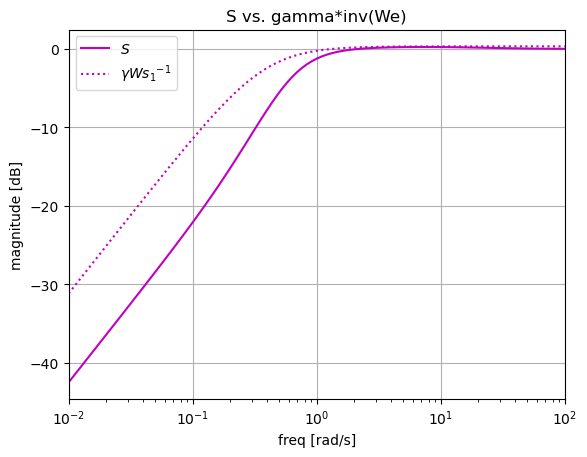

In [5]:
# Frequency range
w = np.logspace(-2, 2, 101)

# Compute sensitivity
I = ct.ss([], [], [], 1) # Identity system
S = ct.feedback(I,P*K)

# Compute singular values of S
Ssv = rb.sigma(S, w)

# Compute singular values of gamma*inv(We)
Weinv = rb.invss(ct.ss(We))
Weinvsv = rb.sigma(Weinv, w) * gamma

plt.semilogx(w, 20*np.log10(Ssv[:, 0]), 'm', label=r'$S$')
plt.semilogx(w, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\gamma {Ws_1}^{-1}$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('S vs. gamma*inv(We)')


Text(0.5, 1.0, 'KS vs. gamma*inv(Wu)')

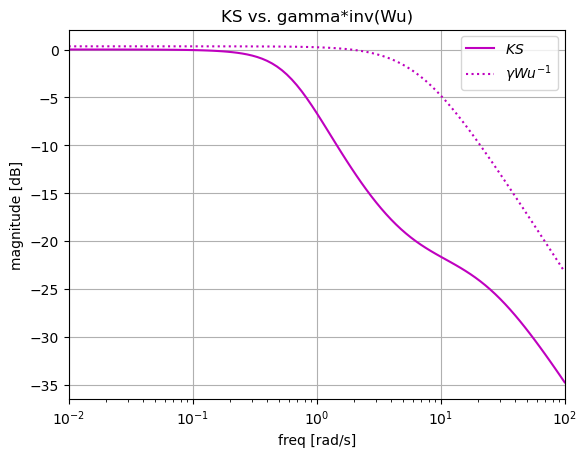

In [6]:
# Compute input sensitivity
KS = K*S

# Compute singular values of KS
KSsv = rb.sigma(KS, w)

# Compute singular values of gamma*inv(Wu)
Wuinv = rb.invss(ct.ss(Wu))
Wuinvsv = rb.sigma(Wuinv, w) * gamma

plt.semilogx(w, 20*np.log10(KSsv[:, 0]), 'm', label=r'$KS$')
plt.semilogx(w, 20*np.log10(Wuinvsv[:, 0]), 'm:', label=r'$\gamma {Wu}^{-1}$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('KS vs. gamma*inv(Wu)')

Now we consider robust stability of this design with respect to a perturbation on the plant. We assume that the uncertainty is a neglected dynamics with time constant $\tau\leq\tau_{max}$.

In [7]:
taumax = 9

# Uncertainty weight for neglected pole
Wi = taumax*s/(1+taumax*s)
display(Wi)

TransferFunction(
array([9., 0.]),
array([9., 1.]),
outputs=1, inputs=1)

We need to compute the transfer function $M_{11}$ from $w_\Delta$ to $z_\Delta$ and check its infinity norm to compute the robust stability margin.

Text(0.5, 1.0, 'M11')

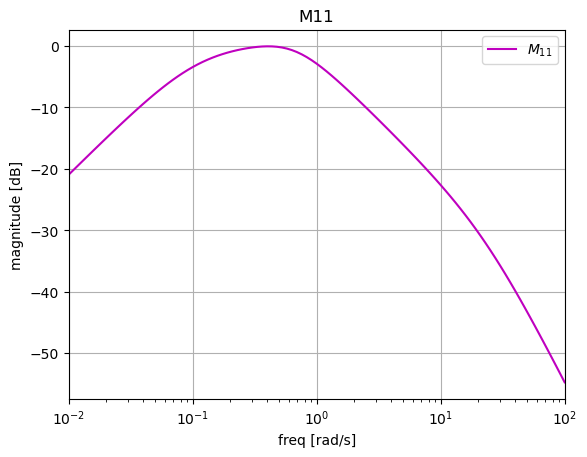

In [8]:
K.input_labels = ['y']
K.output_labels = ['u']
sum_delta = ct.summing_junction(inputs=['u','-wdelta'], output=['up'])
P.input_labels = ['up']
Wi.input_labels = ['u']
Wi.output_labels = ['zdelta']
M11 = ct.interconnect([P, K, Wi, fbk, sum_delta],
                    inputs=['wdelta'],
                    outputs=['zdelta'], check_unused=False)


M11sv = rb.sigma(M11, w)

plt.semilogx(w, 20*np.log10(M11sv), 'm', label=r'$M_{11}$')
plt.ylabel('magnitude [dB]')
plt.xlim([1e-2, 1e2])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.grid()
plt.title('M11')

In [9]:
# Compute the infinity norm of M11
gamma = max(M11sv)

The system is robustly stable if $\|M_{11}\|_\infty=\gamma\leq 1$

In [10]:
display('gamma=', gamma)

'gamma='

array([0.99513279])

We now want to check the stability of the control system with the perturbed plant for the worst value of the neglected pole. First we compute the perturbed plant.

In [11]:
Pp = P/(1+taumax*s)

Then, we compute the closed loop transfer function and the closed loop poles

In [12]:
T = ct.feedback(Pp*K,1)
poles = ct.poles(T)
display('Closed loop poles', poles)

'Closed loop poles'

array([-5.66010316e+07+0.j        , -2.41444701e+01+0.j        ,
       -5.00000000e+00+0.j        , -6.81973188e-03+0.33441473j,
       -6.81973188e-03-0.33441473j, -3.86334514e-01+0.j        ,
       -9.99999998e-01+0.j        ])

Observe that there are two poles which are very close to the imaginary axis, yet they are stable.